# Under Construction! 

# Working with External Web Services
 This example shows how to use external services to set up Cytoscape session with pathways
 
 * Cytoscape 3.2.0 beta
 * [KEGGScape 0.7.x](http://apps.cytoscape.org/apps/keggscape)
 * [cy-rest 0.9.x or later](https://github.com/keiono/cy-rest)
 

## Input and Output

* Input - Disease name
* Output - Cytoscape session file containing all KEGG pathways known to be related to the disease.

## External Services

### KEGG API
###  TogoWS

In [6]:
import requests
import json
import pandas as pd
import io
from IPython.display import Image

# Basic Setup
PORT_NUMBER = 1234
BASE = 'http://localhost:' + str(PORT_NUMBER) + '/v1/'

# KEGG API
KEGG_API_URL = 'http://rest.kegg.jp/'

# Header for posting data to the server as JSON
HEADERS = {'Content-Type': 'application/json'}

requests.get(BASE)

<Response [200]>

## Get list of entries about cancer



In [2]:
# Find information about cancer from KEGG disease database.
query = 'cancer'

res = requests.get(KEGG_API_URL + '/find/disease/' + query)
pathway_list = res.content.decode('utf8')

disease_df = pd.read_csv(io.StringIO(pathway_list), delimiter='\t',  header=None, names=['id', 'name'])
disease_df

,id,name
0,ds:H00013,Small cell lung cancer
1,ds:H00014,Non-small cell lung cancer
2,ds:H00016,Oral cancer
3,ds:H00017,Esophageal cancer
4,ds:H00018,Gastric cancer
5,ds:H00019,Pancreatic cancer
6,ds:H00020,Colorectal cancer
7,ds:H00022,Bladder cancer
8,ds:H00023,Testicular cancer
9,ds:H00024,Prostate cancer


## Get pathway list

In [3]:
disease_ids = disease_df['id']
disease_urls = disease_ids.apply(lambda x: KEGG_API_URL + 'get/' + x)

def disease_parser(entry):
    lines = entry.split('\n')
    data = {}
    
    last_key = None
    for line in lines:
        if '///' in line:
            return data
        
        parts = line.split(' ')
        if parts[0] is not None and len(parts[0]) != 0:
            last_key = parts[0]
            data[parts[0]] = line.replace(parts[0], '').strip()
        else:
            last_val = data[last_key]
            data[last_key] = last_val + '|' + line.strip()
    return data   

result = []
for url in disease_urls:
        res = requests.get(url)
        rows = disease_parser(res.content)
        result.append(rows)

In [4]:
disease_df = pd.DataFrame(result)
pathways = disease_df['PATHWAY'].dropna().unique()

p_urls = []
for pathway in pathways:
    entries = pathway.split('|')
    for en in entries:
        url = KEGG_API_URL + 'get/' + en.split(' ')[0].split('(')[0] + '/kgml'
        p_urls.append(url)

## Import all cancer related pathways

In [5]:
def create_from_list(network_list):
    server_res = requests.post(BASE + 'networks?source=url&collection=' + query, data=json.dumps(network_list), headers=HEADERS)
    return json.loads(server_res.content)

requests.delete(BASE + 'networks')

url_list = list(set(p_urls))
pathway_suids = create_from_list(url_list)

{
    "source": "http://rest.kegg.jp/get/hsa05200/kgml", 
    "networkSUID": [
        35821
    ]
}


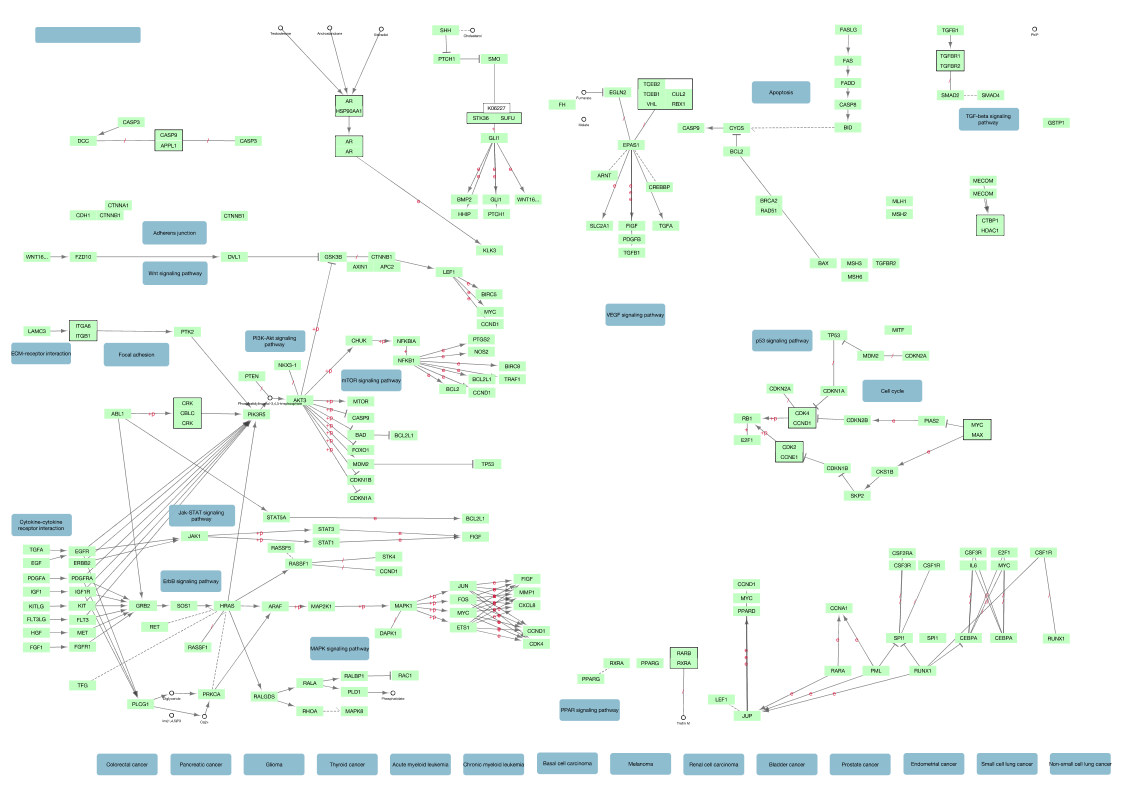

In [17]:
# Check the result.
print(json.dumps(pathway_suids[0], indent=4))

Image(url=BASE+'networks/' + str(pathway_suids[0]['networkSUID'][0]) + '/views/first.png', embed=True)

## Result

![](http://cl.ly/XcVj/cancer_kegg.png)


## Annotate Pathways by External Services

* Get list of genes in the pathway
* ID Conversion
* Interactions


In [74]:
# Find SUID for Cancer Overview Pathway
cancer_overview_pathway_suid = None

for result in pathway_suids:
    if 'hsa05200' in result['source']:
        cancer_overview_pathway_suid = result['networkSUID'][0]
        break
        

rows_res = requests.get(BASE + 'networks/' + str(cancer_overview_pathway_suid) + '/tables/defaultnode/rows')

# Convert it to DataFrame
cancer_df = pd.read_json(rows_res.content)

genes = cancer_df[cancer_df['KEGG_NODE_TYPE'] == 'gene']

gene_set = set([])

count = 0
converted = ''
query_str = ''
for gene_list in genes['KEGG_ID']:
    for gene in gene_list:
        gene_set.add(gene)
        query_str = query_str + gene + '+'
        count  = count + 1
        if count == 99:
            conversion = requests.get('http://rest.kegg.jp/conv/uniprot/' + query_str)
            converted = converted + conversion.content
            count = 0
            query_str = ''
            
conversion = requests.get('http://rest.kegg.jp/conv/uniprot /' + query_str)
converted = converted + conversion.content    

print(len(gene_set))

327


In [88]:
conversion_map = pd.read_csv(io.StringIO(converted.decode('utf8')), delimiter='\t',  header=None, names=['KEGG_ID', 'uniprot_id'])
id_list = conversion_map.drop_duplicates()
type(id_list)

id_list['uniprot_id'] = id_list['uniprot_id'].apply(lambda x: x.split(':')[1])

print(json.dumps(json.loads(id_list.to_json(orient='records')), indent=4))

[
    {
        "KEGG_ID": "hsa:1630", 
        "uniprot_id": "P43146"
    }, 
    {
        "KEGG_ID": "hsa:1630", 
        "uniprot_id": "Q49AK4"
    }, 
    {
        "KEGG_ID": "hsa:836", 
        "uniprot_id": "P42574"
    }, 
    {
        "KEGG_ID": "hsa:842", 
        "uniprot_id": "P55211"
    }, 
    {
        "KEGG_ID": "hsa:999", 
        "uniprot_id": "P12830"
    }, 
    {
        "KEGG_ID": "hsa:1499", 
        "uniprot_id": "B4DGU4"
    }, 
    {
        "KEGG_ID": "hsa:1499", 
        "uniprot_id": "P35222"
    }, 
    {
        "KEGG_ID": "hsa:51384", 
        "uniprot_id": "E9PH60"
    }, 
    {
        "KEGG_ID": "hsa:51384", 
        "uniprot_id": "Q9UBV4"
    }, 
    {
        "KEGG_ID": "hsa:54361", 
        "uniprot_id": "P56705"
    }, 
    {
        "KEGG_ID": "hsa:7471", 
        "uniprot_id": "P04628"
    }, 
    {
        "KEGG_ID": "hsa:7472", 
        "uniprot_id": "P09544"
    }, 
    {
        "KEGG_ID": "hsa:7473", 
        "uniprot_id": "P56703"
    }

In [91]:
new_column = {
    'name': 'KEGG_ID_TOP',
    'type': 'String'
}

first_key_res = requests.post(BASE + 'networks/' + str(cancer_overview_pathway_suid) + '/tables/defaultnode/columns', data=json.dumps(new_column), headers=HEADERS)


In [ ]:
genes['KEGG_ID_TOP'] = genes.apply(lambda row:  row['KEGG_ID'][0], axis=1)

In [118]:
sub_table= genes[['SUID', 'KEGG_ID_TOP']]
sub_table.columns = ['SUID', 'KEGG_ID']

208


In [128]:
merged = pd.merge(sub_table, id_list, on='KEGG_ID')
merged.columns = ['SUID', 'KEGG_ID_TOP', 'UNIPROT_ID']
table_data = json.loads(merged.to_json(orient='records'))

In [133]:
new_table_data = {
    'data': table_data
}

# print(json.dumps(new_table_data, indent=4))

res = requests.put(BASE + 'networks/' + str(cancer_overview_pathway_suid) + '/tables/defaultnode', data=json.dumps(new_table_data), headers=HEADERS)

merged[['UNIPROT_ID']].to_clipboard(index=False, header=False)

## Get PPI network from the list